<a href="https://colab.research.google.com/github/Triveni1349/NPL-LAB/blob/main/NLP_5_9_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                text  target
0  Earthquake shakes the city, buildings collapse...       1
1  Huge wildfire spreading fast, people need to e...       1
2  Floods in the village, rescue teams are helpin...       1
3    Happy birthday to my best friend! Party tonight       0
4     Excited for the new movie release this weekend       0

LogisticRegression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


RandomForest Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50    

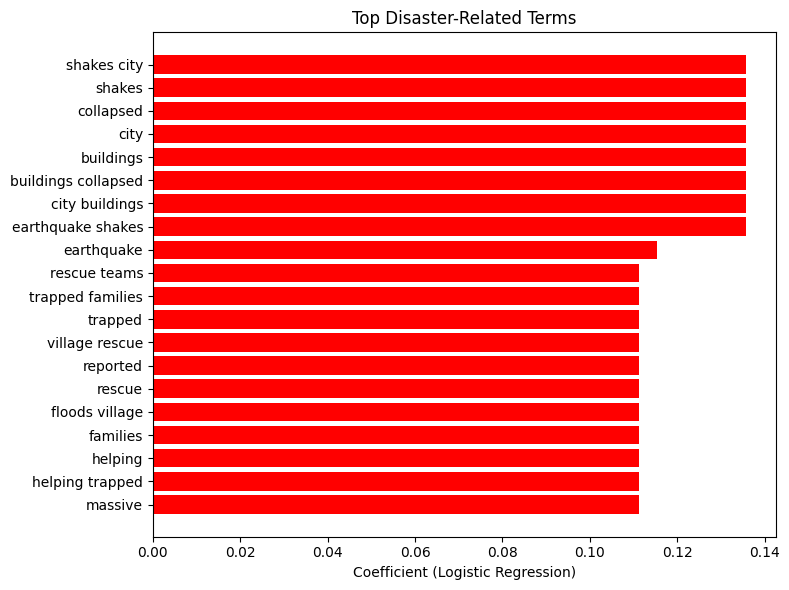

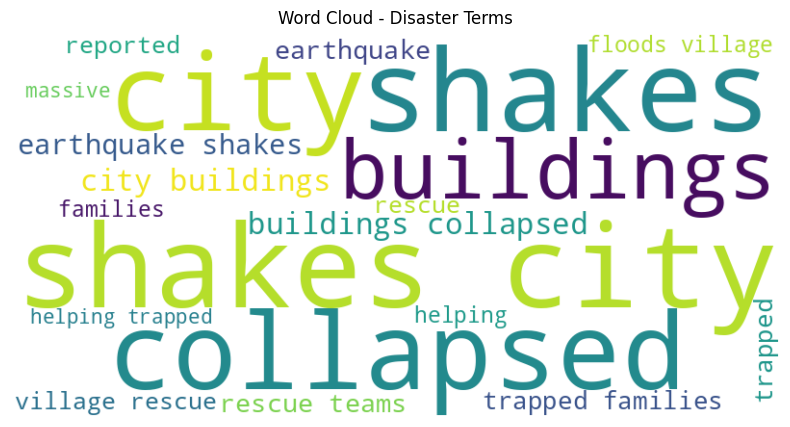


Model Performance Summary:
                    accuracy  precision  recall        f1
LogisticRegression       1.0        1.0     1.0  1.000000
RandomForest             0.5        0.5     1.0  0.666667
DecisionTree             0.5        0.0     0.0  0.000000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from wordcloud import WordCloud


# 1. Load dataset


df = pd.read_csv("/content/sample_disaster_tweets.csv")   # <-- update path if needed
print(df.head())

# Identify text + label columns
text_col = "text"
label_col = "target"

X_text = df[text_col].astype(str).fillna("")
y = df[label_col].astype(int)

# ----------------------------
# 2. TF-IDF Features
# ----------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")
X_tfidf = vectorizer.fit_transform(X_text)

# ----------------------------
# 3. Train/Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------
# 4. Train Models
# ----------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary", zero_division=0)

    results[name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f"\n{name} Results:")
    print(classification_report(y_test, preds, zero_division=0))

# ----------------------------
# 5. Feature Importance (Logistic Regression)
# ----------------------------
lr = models["LogisticRegression"]
coefs = lr.coef_.ravel()
feature_names = np.array(vectorizer.get_feature_names_out())

# Top 20 disaster-related (positive coefficients)
top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_pos = pd.DataFrame({
    "feature": feature_names[top_pos_idx],
    "coef": coefs[top_pos_idx]
})

# Top 20 non-disaster-related (negative coefficients)
top_neg_idx = np.argsort(coefs)[:20]
top_neg = pd.DataFrame({
    "feature": feature_names[top_neg_idx],
    "coef": coefs[top_neg_idx]
})

print("\nTop 20 disaster-related terms:\n", top_pos)
print("\nTop 20 non-disaster-related terms:\n", top_neg)

# ----------------------------
# 6. Bar Chart of Disaster Terms
# ----------------------------
plt.figure(figsize=(8,6))
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1], color="red")
plt.xlabel("Coefficient (Logistic Regression)")
plt.title("Top Disaster-Related Terms")
plt.tight_layout()
plt.show()

# ----------------------------
# 7. Word Cloud of Disaster Terms
# ----------------------------
freqs = {row["feature"]: abs(row["coef"]) for _, row in top_pos.iterrows()}
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freqs)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Disaster Terms")
plt.show()

# ----------------------------
# 8. Show Summary Metrics
# ----------------------------
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)